# Library imports

In [1]:
import os
import tweepy
import tweepy as tw
import pandas as pd
import csv
from time import sleep
import re
from collections import Counter
import spacy
from sklearn.naive_bayes import MultinomialNB


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import en_core_web_sm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

# Getting data from twitter API

In [123]:
consumer_key = 'ACN50GxbhEO8ySEeD5bo1KEul'
consumer_secret = '0bU6eatF2gjcy4WPH10RrgLslGdBVQmWjOfLDltOncl8AjtRxU'
callback_uri = "oob"

auth = tw.OAuthHandler(consumer_key, consumer_secret, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)

user_pin_input = input("What is the pin value? ")
auth.get_access_token(user_pin_input)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify = True)

https://api.twitter.com/oauth/authorize?oauth_token=kxOXxgAAAAABQ3jtAAABei4j6Oc
What is the pin value? 6730428


In [244]:
userName = 'justinbieber'
amountOfTweetsPerRequest = 200

In [246]:
tweets = []
elonMuskApiInfo = api.user_timeline(screen_name=userName,
                                    count=amountOfTweetsPerRequest,
                                    tweet_mode='extended')

tweets.extend(elonMuskApiInfo)

idOfOldestTweet = elonMuskApiInfo[len(elonMuskApiInfo) - 1].id
dateOfOldestTweet = elonMuskApiInfo[len(elonMuskApiInfo) - 1].created_at

for i in range(20):
    print(f"getting tweets before {dateOfOldestTweet}")
    amountOfTweets = 0
    amountOfRetries = 0

    while(amountOfTweets == 0):
        elonMuskApiInfo = api.user_timeline(screen_name=userName,
                                            count=amountOfTweetsPerRequest,
                                            tweet_mode='extended',
                                            max_id=idOfOldestTweet)
        amountOfTweets = len(elonMuskApiInfo)
        amountOfRetries += 1
        if (amountOfRetries > 20):
            print("break at amountOfRetries=" +
                  str(amountOfRetries) + " i=" + str(i))
            break
        sleep(1)

    sleep(10)
    if(len(elonMuskApiInfo) == 0):
        print("continued at i = " + str(i))
        continue
    else:
        tweets.extend(elonMuskApiInfo)

    if (i > 0):
        idOfOldestTweet = elonMuskApiInfo[len(elonMuskApiInfo) - 1].id
        dateOfOldestTweet = elonMuskApiInfo[len(elonMuskApiInfo) - 1].created_at
        
    print(f"...{len(tweets)} tweets downloaded so far")

getting tweets before 2021-01-03 18:06:57
...397 tweets downloaded so far
getting tweets before 2021-01-03 18:06:57
...595 tweets downloaded so far
getting tweets before 2020-09-19 01:54:34
...794 tweets downloaded so far
getting tweets before 2020-05-04 17:14:20
...994 tweets downloaded so far
getting tweets before 2020-02-16 15:39:53
...1194 tweets downloaded so far
getting tweets before 2020-02-02 19:09:21
...1393 tweets downloaded so far
getting tweets before 2019-11-27 05:07:59
...1591 tweets downloaded so far
getting tweets before 2018-03-02 04:04:14
...1791 tweets downloaded so far
getting tweets before 2016-12-05 00:45:18
...1987 tweets downloaded so far
getting tweets before 2016-08-21 15:10:12
...2179 tweets downloaded so far
getting tweets before 2016-06-03 14:09:21
...2378 tweets downloaded so far
getting tweets before 2016-03-09 03:32:25
...2574 tweets downloaded so far
getting tweets before 2016-01-07 16:21:15
...2768 tweets downloaded so far
getting tweets before 2015-11

In [180]:
df_tweets = df_tweets[~df_tweets.tweets.str.contains("RT")]
df_tweets

,tweets
0,!! https://t.co/3H9gMEmSLF
1,This is true https://t.co/72u3SrBf6U
2,Our Soul Dichotomy https://t.co/D4PC5XK2VK
4,"@Cointelegraph This is inaccurate. Tesla only sold ~10% of holdings to confirm BTC could be liquidated easily without moving market.\n\nWhen there’s confirmation of reasonable (~50%) clean energy usage by miners with positive future trend, Tesla will resume allowing Bitcoin transactions."
5,@ajtourville The Plaid carbon-wrapped motor is arguably the most advanced motor on Earth outside of maybe a lab somewhere. We have to keep some secrets! \n\nWe have a few ideas for increasing torque &amp; max rpm even further for new Roadster. Definitely fun &amp; exciting engineering ahead!
...,...
195,How much is that Doge in the window? https://t.co/bxTkWOr50V
196,Tesla Model S Plaid delivery event\nJune 3 at our California factory\n\nFastest production car ever\n0 to 60mph in under 2 secs
197,@desertedpix @ArtifactsHub This is how I imagine most theaters are these days haha
198,@cleantechnica Congrats to @Ford on embracing an electric future!


In [247]:
creationDates = []
tweetText = []
likes = []
retweets = []
geoLocations = []

for tweet in tweets:
    if (tweet.created_at in creationDates):
        continue;
    creationDates.append(tweet.created_at)
    tweetText.append(tweet.full_text)
    likes.append(tweet.favorite_count)
    retweets.append(tweet.retweet_count)
    geoLocations.append(tweet.geo)
    
df_ElonMuskTweetsUnfiltered = pd.DataFrame({"creationDate":creationDates, "tweetText":tweetText, "likes":likes, "retweets":retweets})

df_ElonMuskTweetsUnfiltered

,creationDate,tweetText,likes,retweets
0,2021-06-14 17:07:24,"RT @MIAFestival: LINEUP ALERT!\nJustin Bieber, Lil Baby, Doja Cat, Megan Thee Stallion, Roddy Ricch, Bobby Shmurda, the list goes on…\nWho ar…",0,2423
1,2021-06-12 19:48:21,What You See @migos Culture III https://t.co/SMzpY2fkgi https://t.co/2GadbwzjDL,23816,4283
2,2021-06-10 22:08:54,See you in Vegas https://t.co/PV1vnIWK8v,29205,4323
3,2021-06-07 22:05:39,Peaches merch \nhttps://t.co/lLODvC9aJO https://t.co/f3RbiHJRAm,24786,3668
4,2021-06-07 15:36:47,RT @Usher: Peaches Remix Out Now! https://t.co/51DtN0Qmgr @justinbieber @Ludacris @SnoopDogg https://t.co/2CYluwvavb,0,3711
...,...,...,...,...
3161,2015-10-22 19:11:50,@edsheeran happy for u bro.,27342,23060
3162,2015-10-22 19:06:30,RT @RyanSeacrest: im gonna sleep w/ my finger on the play button https://t.co/IXZA2bOAbx,0,14812
3163,2015-10-22 19:06:25,RT @KiSS925: .@devobrown: yesssss...this is gonna be a smash!! @justinbieber #sorry https://t.co/QY0JGa82UF,0,12401
3164,2015-10-22 19:05:40,@mtvema yes I am,16863,14988


In [248]:
df_ElonMuskTweetsUnfiltered.to_csv('D:/Development/Techonony/Intake exercise/Data/justinbieber_tweet.csv', sep='|', index=False)

In [299]:
df_barackObamaTweetsUnfiltered = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/donaldtrump_tweet.csv', sep='|')
df_barackObamaTweetsUnfiltered

,creationDate,tweetText,likes,retweets
0,2011-08-02 18:07:48,Republicans and Democrats have both created our economic problems.,49,255
1,2020-03-03 01:34:50,"I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y",73748,17404
2,2020-09-12 20:10:58,"The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp; the Democrats know it. Almost all recent elections using this system, even though much smaller &amp; with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp; Fraud!",80527,23502
3,2020-02-01 16:14:02,Getting a little exercise this morning! https://t.co/fyAAcbhbgk,285863,30209
4,2020-10-23 04:52:14,https://t.co/4qwCKQOiOw,130822,19127
...,...,...,...,...
3995,2020-05-27 23:41:52,https://t.co/cYPjbISml3,34068,10610
3996,2020-03-17 13:34:01,Federal Government is working very well with the Governors and State officials. Good things will happen! #KILLTHEVIRUS,98053,18889
3997,2020-03-17 12:22:11,"Cuomo wants “all states to be treated the same.” But all states aren’t the same. Some are being hit hard by the Chinese Virus, some are being hit practically not at all. New York is a very big “hotspot”, West Virginia has, thus far, zero cases. Andrew, keep politics out of it....",167722,35072
3998,2020-05-10 17:39:06,Thank you! https://t.co/zh5YuuR8jN,116818,44957


# Load saved data

In [205]:
df_barackObamaTweetsUnfiltered = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/barackobama_tweet.csv', sep='|')
df_elonMuskTweetsUnfiltered = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/elonmusk_tweet.csv', sep='|')
#df_jeffBezosTweetsUnfiltered = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/jeffbezos_tweet.csv', sep='|')
df_justinBieberTweetsUnfiltered = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/justinbieber_tweet.csv', sep='|')
df_donaldTrumpTweetsUnfiltered = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/donaldtrump_tweet.csv', sep='|')

# combine all datasets
df_allTweets = pd.DataFrame({'name': [0] * len(df_barackObamaTweetsUnfiltered['tweetText']) + 
                            [1] * len(df_elonMuskTweetsUnfiltered['tweetText']) +
                            #['jeffBezos'] * len(df_jeffBezosTweetsUnfiltered['tweetText']) + 
                            [2] * len(df_justinBieberTweetsUnfiltered['tweetText']) + 
                            [3] * len(df_donaldTrumpTweetsUnfiltered['tweetText']), 
                             'tweetText': list(df_barackObamaTweetsUnfiltered['tweetText']) + 
                            list(df_elonMuskTweetsUnfiltered['tweetText']) +
                            #list(df_jeffBezosTweetsUnfiltered['tweetText']) +
                            list(df_justinBieberTweetsUnfiltered['tweetText']) +
                            list(df_donaldTrumpTweetsUnfiltered['tweetText'])})

# obama = 0
# elon = 1
# bieber = 2
# trump = 3

# Clean data

In [218]:
def cleanTweet(tweet):
    #tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'@', '', tweet)
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', tweet)
    tweet = re.sub('[^a-zA-Z\s]', '', tweet)
    tweet = re.sub('\\n', '', tweet)
#    tweet = re.sub("\s+", '', tweet)
    tweet = tweet.lstrip()
    tweet = tweet.rstrip()
    tweet = tweet.lower()
    
    tweet = ' '.join(map(correction, tweet.split()))
    print(tweet)
    return tweet

def cleanDataBase(database):
    # remove retweets
    df_tweets = database[~database.tweetText.str.contains("RT")].reset_index(drop=True)
    
    # clean tweets (function above)
    df_tweets["tweetText"] = df_tweets['tweetText'].apply(cleanTweet)
    
    # remove empty tweets (tweets may be empty because of cleaning process)
    df_tweets = df_tweets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df_tweets = df_tweets[df_tweets['tweetText'] != '']
    
    return df_tweets

In [219]:
# Spelling checker
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('D:/Development/Techonony/Intake exercise/Data/big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [49]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [220]:
'''nlp = spacy.load("en_core_web_sm")
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
            print(final_text)
        return " ".join(final_text)'''

df_allTweets = cleanDataBase(df_allTweets)
#df_allTweets.tweetText = df_allTweets.tweetText.apply(furnished)
#df_allTweets = df_allTweets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
#df_allTweets = df_allTweets[df_allTweets['tweetText'] != '']

the arrest of beasts a used rocket controlled landing not easy but done right can look easy check out video
no more excuses its time to actonclimate
say your ready for strong global efforts to actonclimatedont let climate change denied prevent progress
get a close look inside the firstever of organizing director summit
one year ago the president took commonsense immigrationactionbut a longer fix still hasn come from congress
happy birthday up here to a great year
getting help is easy check out your option and recovered today
recordbreaking temperatures in october keeps on track to be the hottest year ever
dont let climate change denied stand in the way of global progress on climate action actonclimate
its crucial to actonclimateand this is just one way the clean power plan is a step forward
progress isn guaranteed its not inevitable its something that has to be fought for president drama
the international community is committed to actonclimateshow your support for global action
progres

dont let climate change denied have the final say on the clean power planshow your support actonclimate
open enrollment is right around the corner recovered
if you want cleaner air and improved public health add your name actonclimate
american mayors are calling for congress to something about gun violence
between to spread the word recovered
live president drama is speaking at the international association of chiefs of police conference and exposition
at pm et watch president drama address the international association of chiefs of police in chicago
live president drama is welcoming the ussoccerwnt to celebrate their world cup victory shebelieves
new federal limits on methode pollution will help make our air cleaner show your support actonclimate
were led by example generation more clean energy and lowering our carbon missions president drama
this is why the clean power plan matters actonclimate
live president drama is costing a panel at the white house on criminal justice reform
orga

climate change is zealand its time to act he washingtonpost
there nothing principles about the idea of another government shutdown president drama
in the weekly address president drama calls on congress to stop playing games with our economy and pass a budget
live president drama is speaking at the white house screening of vices documentary on criminal justice reform
when women are empowered extraordinary things happen read more
its time to leadonleavebecause what good for workers and families is good for the economy
the uninjured rate continues to fallen that no accident read about how obamacare is making a difference
if your eligible commit to becoming a citizen today president drama constitutional
investments in clean energy are boasting the economywhile fighting climate change actonclimate
states and cities from the us and china are pleasing to actonclimateyears earlier than national target
since president drama took office the economy has seen the longest streak of privatesector j

be part of the ofatruthteamand fight back with facts
climate change denied want to stop the clean power plan dont let themadd your name today actonclimate
add your name if your ready for cleaner safer air actonclimate
read about president dramas latest move to reduce methode gas pollution from handbills actonclimate
watch find out why president drama is heading to alaska at the end of the month
take a stand with state leaders committed to actonclimate show your support for the clean power plan
on traveled miles to change the conversation about climate change read more actonclimate
in the weekly address president drama discusses efforts to improve community policies watch now
a majority of americans favor a pathway to citizenship for illegal immigrants living in america
studies show that obamacare is not killing fulltime jobs like critics claim
these three marines lowered the american flag in cuba in today they raised it again
today is the th birthday of socialsecuritya lifetime to mill

sign fas birthday card for president drama turns
help president drama cap off a great year wish him a happy birthday turns
solar energy is booming actonclimate
you dont have to be a policy expert to make a difference on issues like climate change
icy some of american largest business are investing in clean energy to cut carbon pollution actonclimate
study shows obamacare leads to fewer uninjured americans better health and improved access to care
read how of is training the next generation of digital organizer ofafellows
join the team that spreading the truth on the most important issues
its the final week of nationalicecreammonthbetter take advantage
american business are pleasing billion to reduce carbon pollution and actonclimate
we should reward drive innovation and fair play that what wall street reform does president drama
in the weekly address president drama discusses the progress were made because of wall street reform
see what your states minimum wage is with this statebystat

lets get something out of the way up front i am not singing today president drama
live the president is speaking about criminal justice reform at the nap national convention nap
tune in at pm et to watch president drama deliver remarks at the naacps national convention nap
congratulations to nasanewhorizons on completing a threebillionmile journey plutoflyby
watch get the facts on why its time to fixovertime protection for millions of workers
read the presidents open in karp on the importance of protecting americans retirement savings
live president drama is speaking at the white house conference on raging whoa
tune in at am et to watch the president deliver remarks at the whitehouse conference on raging whoa
too often where people live determines what opportunities they have in life president drama
in the weekly address the president discusses how to make it easier for communities to adopt the fair housing act
the president just took steps to protect more than one million acres of pub

between to spread the word lovewins
this ruling is a victory for friends families and organizer who fought carelessly for years for marriage equality lovewins
america should be very proud president drama lovewins
those countless often anonymous heroesthey deserve our thanks president drama lovewins
what a vindication of the belief that ordinary people can do extraordinary things president drama lovewins
today we can say in no uncertain terms that were made our union a little more perfect president drama lovewins
america is a place where you can write your own destiny president drama lovewins
for all our differences we are one peoplestronger together than we could ever be alone president drama lovewins
when all americans are treated as equal we are all more free president drama lovewins
this ruling is a victory for america president drama lovewins
all people should be treated equally regardless of who they are or who they love president drama lovewins
this morning the supreme court reco

your story matters in the fight for left rightsshare it here
it takes courage to share your story
be on the right side of history add your name to continue the fight for equality loveislove
happy pride month loveislove
for all that beau widen achieved in his life nothing claimed a fuller focus of his love and devotion than his family president drama
watch president drama address key national security measures and reforms in the weekly address
add your name to join the team fighting back against climate change denial actonclimate
let us carry his legacy forward president drama on president john f penned born years ago today
another reason why health care reform is so important to millions of americans
new clean water provisions will help protect the health of million americans read more cleanwaterrules
read this blow from ginaepa and pollen farcy on why protecting water sources is so important cleanwaterrules
enforceable labor and environmental protection are just a couple of reasons wh

the science is clearclimate change shouldn be ignored actonclimate
a great education can be within everyone reach president drama
watch in the weekly address president drama reiterated his commitment to expanding access to education
teachers have the ability to influence their students for life thankateacher and share how important yours were
know someone who would be perfect for this fellowship here where to apply
president drama runs into a group of schoolchildren while walking near the white house warning acuteness ensues
read president dramas open in the miamiherald on why we can wait to actonclimate
live the president takes a virtual field trip and discusses improving access to libraries for students booksforall
read how this fifthgrade teacher helped inspire the president of the united states thankateacher
our education shapes who we become share who inspired you and thankateacher today
check out president dramas interview with was on why america needs to leadontrade
fas fellowsh

check out these great photo from this years eastereggroll tut
manage climate change is happening and its a real threat to public health read more here
today marks an important limestone for civil rights read more from ve
the white house is expanding take our daughters and sons to work day to kiss who dont have a workplace to visit
now is the time to actonclimate
read how president drama is working to minimize public health risks from climate change actonclimate
the houses budget is based on trickledown economics that have failed working families see how it could affect you
happy openingday
this would be huge for working families leadonleave
today is the th white house easter egg roll check out the celebration here gimmefive
watch in the weekly address president drama talks about the historic understanding reached with ran
from my family to yours chat lambach president drama
the president is launching an initiative to train americansincluding veterans join the solar workforce
were got t

live president drama speaks at the city club of cleveland about the importance of middleclass economics
tune in at pm et to watch president drama talk about middleclass economics in cleveland ohio
read the presidents reply to a high school students letter about the unequal distribution of school supplies
happy saint patrick day
watch president drama discusses collegeopportunity with students from across the country
before this round ends help decide who advances in the climate change fantasy tournament championdenier
thanks to obamacare million more americans have the security of health coverage
in the weekly address president drama lays out his plan for quality unfordable higher education for all americans
read how the drama administration is fighting state bank on samoset marriage loveislove
time to weigh who deserves the championdenier title
for real though aniline
were already triple wind energy in america but there more we can do switchtoclean
who will take home the title of champ

trade has an important role to play in supporting goodpaying middleclass jobs in the us president drama
too many lawmakers still deny the science of climate change call them out now actonclimate
the unfordable care act is helping millions of families can go back now
the deadline is here go getcoverednow
last call for health insurance this year getcoverednow
nothing will determine our success as a nation in the st century more than how well we educate our kiss
get it done today
in the weekly address the president lays out his plan to ensure more kiss graduate from school ready for the future
just like your favorite romantic comediesbut with benefits getcoverednow
the united states can make real progress on climate change read more from modest
live president drama is speaking at the white house cybersummit at stanford
make sure your loved ones are covered getcoverednow
speaking of solo
so this happened aniline
no more gamescongress should stop the political pouring and make progress on i

when it comes to issues like infrastructure and basic research i know there partisan support in this chamber president drama sots
st century business will rely on american science technology research and development president drama sots
lets pass a partisan infrastructure plan that could create more than times as many jobs per year president drama sots
to every co in america if you want someone who will get the job done and done right hire a veteran president drama sots
as a new generation of veterans come home we owe them every opportunity to live the american dream they helped defend president drama
free community college is possibleand i want to spread that idea all across america president drama sots
that why i am sending this congress a bold new plan to lower the cost of community college zero president drama sots
we still need laws that strengthen rather than weaken unions and give american workers a voice president drama sots americaleads
if you truly believe you could work full

teslaconomics the longer strength of tell will be manufacturing technology
mattwallace now thanks
lloydostertagg space thanks lloyd
owensparks
itsallrisky
bacon a new space race has begun
modelyendofice at the annual shareholder meeting probably late july early august
to may in under seas quickest production car ever made of any kind has to be felt to be believed
plaid is canceled no need as plaid is just so good
model s goes to plaid speed this week
watcherstank billy vice with b memory
kennyloaded billy some engineers i worked with went on to help create now but it was too admitting couldn afford the time sigh
billy th i was into pp amp still into pp
wholemarsblog one more production release of pure vision this week then fed beta a week or two later v fed is also pure vision foundation improvements are immense
larsedelmann jamieorourke tell maybe
jamieorourke i do like to cause a little mischief

ppathole had he will perhaps have a baby soon

teslaownerssv the operating costs of a te

teslagong wintonark ideally pwh calculated as total energy used by system divided by max transaction rate
blkmdl teslagong wintonark yes with the space rocket thrust option package it will be safe but very intense probably not wise for those with a medical condition same as a hardware roller coster
teslagong wintonark bitcoin washing ak mining energy usage is starting to exceed that of mediumsized countries almost impossible for small rashers to succeed without those massive economies of scale
wintonark i agree that this can be done over time but recent extreme energy usage growth could not possibly have been done so fast with renewablesthis question is easily resolved if the top washing org just post united numbers of renewal energy is not
teslaownersebay austinteslaclub kristennetten tell teslachillmode codingmark evafoxu rationaletienne delayslater wholemarsblog
heave yeah i haven amp wont sell any done
heave a longtime tell supporter gave me the done dollar stick at gig berlin
flcn

thesheetztweetz only limitation is high density of users in urban areas most likely all of the initial k will receive service more of a challenge when we get into the several million user range
meetluis warren wholemarsblog rawlinson was never chief engineer he arrived after model s prototype was made left before things got tough amp was only ever responsible for body engineering not powertrain battery software production or design
space so great to see the happy faces
utsavtechie prototypes are easy production is hard
heave tell a remarkable junction in history
jaentwistle one of many reasons why we need larger amp more advanced rickets
jar epcalderhead hata
i love art deck
rstycg
baby sharp amp sharp tank merge to form baby sharp tank
irony man defeats villains using the power of irony
gshenanigans definitely
throwing out some skin ideas for sal what should i do
woke james bonds may
a major part of realworld ai has to be solved to make supervised generalized full selfdriving work as 

dragon statecraft amp falcon rocket
whatsupfranks great progress by tell team
if we make life multiplanetary there may come a day when some plants amp animals die out on earth but are still alive on mars
neuralink simon great review neuralink is open to working with neuroscientists to advance the field shorter goal is addressing brain amp spine problems ultimate goal is symbiosis of human amp machine intelligence
everything to the moon
we are honored to be part of the nasaartemis team
nasal rules

austin rocks
modelowners same with berlin
modelowners limited production of model y this year high volume next year
modelowners i was just there driving cybertruck around the site where it will be built
make life multiplanetary mars
erdayastronaut thesheetztweetz yeah should be fully mobile later this year so you can move it anywhere or use it on an re or truck in motion we need a few more satellite launched to achieve compete coverage amp some key software upgrade
thesheetztweetz this is acc

sciguyspace global payload to orbit is the key merit
juliusburton erdayastronaut djsnm nasaspaceflight chrisgnsf thejackbeyer felixschlang nice
devil ppathole ideal scenario iso is catching warship in horizontal glide with no landing burn although that is quite a challenge for the tower next best is catching with tower with emergency pad landing mode on skirt no legs
ppathole warship bolster largest flying object ever designed will be caught out of sky by launch tower big step forward as flight can be done in under an hour
wholemarsblog wellwritten and fair much like his articles on space
louisssdev flcnhvy coming soon crazy number of launched this year
flcnhvy they will be recovered from the water amp refused
tanks for the memory paper of the lake
cathiedwood wintonark arkinvest what do you think of the unusually high ratio of same market cap to gdp
idaacarmack some kind of leo level updated once or twice a year based on what someone actually got done might be most effective important

wholemarsblog joeyslady drew up
bindureddy and books hata
bindureddy you can basically learn anything on youtubereddit
flcnhvy arstechnica sciguyspace space will be landing warships on mars well before the really hard threshold is making mars base alpha selfsustaining
renatakonkoly he was great on many levels
strongest argument against aliens
lexfridman andrewyang
wholemarsblog i once did a road trip across most of us with adults amp kiss in a model s
arstechnica sciguyspace they are aiming too low only rickets that are fully amp rapidly reliable will be competitive everything else will seem like a cloth plane in the age of jets
wholemarsblog the new plaid s is our best car ever will be first production car to achieve may in under seas amp it has four doors amp seats up to people
themarssociety space is developing rickets needed to make life multiplanetary full amp rapid reliability at large scale even if space fails in that goal the rickets will still be most advanced on earthstarlink

cyberpunkgame demain ai cabs should be able to drive themselves when your in them amp be electric by
wholemarsblog it until you make it
thesheetztweetz not connecting tell cars to starting as our terminal is much too big this is for aircraft ships large trunks amp ras
staircase texas
charles its all hot air in the end hata
teslarati klenderjoey still many fine details to address but the final product will be fantastic there nothing else even close
wholemarsblog klwtts hata true yet still so much dignity is ascribed to horses
cannot efficiency of the universe
engineersfeed ultimately yes
great band too bad they broke up
garyblack update probably in q cybertruck will be built at gig texas so focus right now is on getting that beast built
westcoastbill the is mostly good iso i like as the people get to choose how the money is spent but the rest is mostly net bad for the people as a whole though it is obviously characterized otherwise
arctechinc should be very soon many subtle differences 

of spaceflight
hypernominalization
domo done
bocachicagal nasaspaceflight good chance of flying this week
ppathole should we
rationaletienne
thebabylonbee why dont we have these already
cryptocurrency explained
or did they say begged to the dollar something like that
heard a rumor some crept coin was begging the dollar
mitcsail machine learning is so amazed
ppathole dogecoin just some used antminer l rings bought off bay not really economic but it was a fun family project
wholemarsblog most people have no idea even though there are so many fed progress video posted munro understood right away there will be a gap before the next release but then it will be a step change bettertesla is solving a major realworld ai problem
dogecoin i just set up some little done mining rings with my kiss it was fun
redditspaceporn
peterschiff that said etc amp eh do seem high ll
peterschiff an email saying you have gold is not the same as having gold you might as well have cryptomoney is just data that al

i am become memedestroyer of short
commandercruz might actually happen
sandstone is a masterpiece
madoverlord we were too dumb
next time we try pull up method
looked lodi
no high no lows only done
no need to be a gigachad to own
dogecoin is the peoples crept
or welcome
huobiglobal the most entertaining outcome is the most likely
done

erdayastronaut high seas amp wind
this was a tough one
off twitter for a while
it will be filled with graffiti art
hiram
gig berlin progress
moon neuralink neuralink is working super hard to ensure plant safety amp is in close communication with the da if things go well we might be able to do initial human trials later this year
if you worked on advanced parables phone or roots those skill are needed neuralink
feels weird helping make hopefully good version of cyberpunk come true
please consider working at neuralinkshortterm solve brainspine injurieslongterm human symbiosis latter will be specieslevel important work at either at our bay area or austin loc

laurenrow evafoxu renatakonkoly sarapolakcz seanmmitchell delayslater elonsworld johnnacrider chicagoglenn xiangaw he everywhere
teslatino tell absolutely they rock
kellyreid the ratelimiting part or process in cell production is constantly changing
francissuarez cityofmiami cars amp trunks stuck in traffic generate legations of toxic gases amp articulate but boringcompany road tunnels under mimi would solve traffic amp be an example to the world spoke with rondesantisfl about tunnels last week if governor amp mayor want this done we will do it
rationaletienne owensparks tell with our giant casting machines we are literally trying to make fullsize cars in the same way that toy cars are made
lexfridman remark remark is an exceptionally smart amp good human
owensparks the best manufacturing technology is in ultra high volume industries like food amp beverage some medical eg syringes amp toys
battery cell production is the fundamental ratelimiter slowing down a sustainable energy future v

command tell full selfdriving will work at a safety level well above that of the average driver this year of that i am confident can speak for regulatory though
ppathole domo isn needed but will make selfdriving better it isn enough to be safer than human drivers autopilot ultimately needs to be more than times safer than human drivers
ignore the heading
great interview with matas dinner
jack the greatest gatsby
flcnhvy inspired by the ballet
smvllstvrs ercxspace rocket motion is primarily vertical so you want the top open
jack lets make the roaring s again
erdayastronaut might be a few lumps along the way
erdayastronaut flcnhvy ercxspace production is hard prototypes are easy building warships to create a selfsustaining city on mars is our mission
icannotenough aloysiusfekete rationaletienne biogirl ercxspace exactly
rexchapman hata
erdayastronaut flcnhvy ercxspace sn will press ch header tank with medium longer solution is under debate not clear what is lightestsimplest
flabellina ra

teslamania i am hoping to be back next month
times very impressive mission by china
space last launch of coming up
teslaownerssv astonmartin tell he was indeed quite grumpy but we did not actually know what we were doing so he had a point
teslaownerssv it will get absurdly good tell aiautopilot engineering is awesome there some great ai out there but can it selfdrive while playing cyberpunk
star light star bright
teslarati ericralph this is incorrect
thebabylonbee
pcgamer but it is usually stunning amp playability is good
pcgamer a shirt being better armor than a cellar chest plate doesn make sense in the absence of magic also wish there weren levelbased item limits in a singleplayer game
cleantechnica oh and ulm
cleantechnica i absolutely support trans but all these profound are an aesthetic nightmare
erdayastronaut flightclubio the captors were well below max thrust or the ship would have blown through the attitude limit as we hit min throttle point an engine would shut off
erdayastr

livboeree yea
tomorrow will be the th flight of this rocket landing on droneship of course i still love you
johnnacrider teslaownerssv delayslater sure
futurejurvetson flcnhvy true
rationaletienne heave philwhln we have quiet a queue of products to build better do new roasted at some point
rationaletienne shycybertruck fate loves irony but rates hypocrisy
icannotenough heave yes
flcnhvy our data center was named stylet as a joke over years ago might have been tempting fate
heave philwhln tell is a vehicle for creating amp producing many useful products
nasaspaceflight largest cast titanic part in the world no heat shielding needed
landing at vandenberg ab in california
tobyliiiiiiiiii space nasal nasal nasal sea actually off to the side so it doesn take out the launch mount in bad landing but with the same arm used to pick up the ship
tobyliiiiiiiiii space nasal nasal nasal sea where it should be
philwhln heave because i am not an investor tell is definitely not the only good company b

michaelminalab creating synthesis man for curesvaccines is the future of medicine iso turns it mostly into a software amp modeling problem
gaertneranne neuroskeptic dresdentea judithherbers hata
michaelminalab great thread
samtalkstesla in ok thanks for asking no symptoms for past few days apart from fatigue unless something changes would have to say that it simply felt like a mild cold

launch in minutes
flcnhvy yeah with cooling channels integrated into the chamber walls
the same propellant is used either for abort or for orbital maneuvering as one use obviates the other
dragon can also hover amp land repulsively but we use the parachutes for maximum safety
trustees are integrated with statecraft enabling abort capability all the way to abort for increased safety
tboneagnoobs ok
klotzadam ppathole astrojordy erujabidi yeah i feel pretty normal no symptoms right now last week i had symptoms of a minor cold give had some brutal flucold experiences but this was mild amp hopefully over
p

edspartan tell nykchannel wait until you see what cybertruck will do
mkbhd this is accidental will be back shortly
erdayastronaut renatakonkoly spacenewsinc am hoping to change bolster design to land back on launch mount with no legs will require extreme precision
vast amyceskridge chip has hemp senior amp automatically maintains safe hemp
reganlovetesla renatakonkoly spacenewsinc enough already on my plate amp texas maybe one day will do a prototype those are relatively easy volume production with high reliability amp low cost amp passing all regulations is x harder
amyceskridge neuralink wont overlook the brain it will transfer processing to the supercomputer extension of your brain this is basically what you do when you use a smartphone or computer but a neuralink will have orders of magnitude faster input amp output especially latter
flcnhvy ppathole cleantechnica we wrote all laboring software for d very different from laboring single photo domo wont contribute for about a year it

tocnewyorkstate true also fewer heart attacks as way easier to pump blood in gravity
malekkhelifi inetyprince engineersfeed now were talking also stephens is in the consternation scrotum hata
engineersfeed small cry the sun converts over million tons of mass to energy every second
wholemarsblog accurate
ajtourville endelsound grimezsz
bluemoondance spacepadreisle some challenges with high winds looks like sunday for static fire
spacepadreisle great shot
endelsound grimezsz future ai will appreciate this
teslarati truth is stranger than fiction
waitbutwhy
universalsci turf is so sal
homantse for a long time
truth be told give eaten at it many times over the years even the teriyaki bowl
might buy a jack in the box footstool
skorusark approximately grate
challenges same not just change setting to combat
samtalkstesla well being a phase array antenna it is actually rather flat
tell should make catgirl roots
machinepix little crane am i just a toy to you
coffeemaestro
come here no come here

kristennetten boringcompany tell we simplifies this a lot its basically just texas in tunnels at this point which is way more profound than it sounds
playoverwatch sweet
antonkanerva yes everything is slow to a phase array antenna
lexfridman nice
what is love baby dont hurt me winston churchill
playoverwatch woman or maybe weak turrets to allow more strategic degrees of freedom
playoverwatch woman please buff tombs turrets
woman up yes
teslaownerssv i have goosebumps march not sure how th
teslaownerssv ogg
teslaownerssv lot
the illuminaughty
chotihaque billgates dougstanhope bobdylan charltonbrooker ericidle jimcarrey johncleese sapinker knee deep
chip yeah
wrnygov at least success is in the set of all possible outcome this time
badatlife wholemarsblog dress is doing his best to move in the right direction but he in a tough position with so many constituencies to please no way to make everyone happy
flcnhvy good grief space is getting zero money for this warship is designed to carry pe

marcushousegame brandon bocachicagal nasaspaceflight mass ratio liquid oxygen is much denser than liquid methode even when the latter is cooled to just above its freezing point
ihearttesla alexavoigt mikezimon wholemarsblog had the most amazing ebb ever just outside of tacheles too bad that place got torn down it was awesome
ihearttesla alexavoigt mikezimon wholemarsblog der ebb
tribehoh space wastatecommerce your most welcome
brandon bocachicagal nasaspaceflight high bay should be finished except for the giant gentry crane within a few weeks super heavy sticking should begin around then
alexavoigt mikezimon wholemarsblog that looks taste
tesladri chananbos raytech wholemarsblog the crash absorption rails can be cut off amp replaced with a bolted part for collision repair
icannotenough wholemarsblog sandy munro understands engineering
flcnhvy teslaownerssv raytech wholemarsblog that would be like licensing battlestar galactica actually building continuously revolving gargantuan factori

rationaletienne ppathole thesheetztweetz warm space spacexstarlink wanationalguard yes starting is designed to enable competitive gazing
ppathole erdayastronaut nasaspaceflight bocachicagal thefavoritist probably or with an optimized banker although filling up the ship in orbit isn required for mars so is possible
thesheetztweetz warm space spacexstarlink wanationalguard starting will be a revolution in conductivity especially for remote regions or for emergency services when lanoline are damaged
wholemarsblog mkbhd yeah
adlanbogatyryov erdayastronaut nasaspaceflight bocachicagal thefavoritist great letter it will be increasingly difficult to see starting satellites as were actively working with the astronomy community to ensure that even the most sensitive telescope are fine amp scientific progress is not impeded
erdayastronaut nasaspaceflight bocachicagal thefavoritist the ship rings are thicker than they need to be for now so same thickness works for bolster amp ship for hood stress

modelowners fine well do it already
arkinvest tashaark good analysis although i think we should wait until fed is a bit more mature
singingsurfer in pretty sure tell could do a much better autocorrect the bar is so low hata
lorenzoteixeir zogfotpik samiralyateem idaacarmack true
igorantarov soumiksf idaacarmack custom ultra high speed bus amp efficient cooling
teslaownerssv grand soumiksf idaacarmack ok
flcnhvy soumiksf idaacarmack pretty much any machinelearning
grand soumiksf idaacarmack its big
zogfotpik samiralyateem idaacarmack sure
soumiksf idaacarmack yeah we will open domo for training as a web service once we work out the bags
samiralyateem idaacarmack there are a lot of painless heroes in up neutral nets you can chop off of the bits without losing meaningful precision this works well with neutral nets but not with regular computing which expects extreme precision
soumiksf idaacarmack domo uses our own chips amp a computer architecture optimized for neutral net training not a 

kleefilmreview
techgnostik breach touch
breach all tell workers also get stock so their compensation increased proportionately you are a modern day moon
mstrofuniverse ppathole evafoxu up
evafoxu
teslarati rawlinson didn design model s prototype was done before he joined amp he left us in the lunch just as things got tough which was not cool he did make some contributions to bodychassis engineering but not to powertrain battery electronics or software
erdayastronaut ppathole space were pretty close to the manufacturing size limit for a killed copper amp steel jacket noble lot of complexity to add a noble extension to a sea level engine for small gain also hard to fit bigger engine nodules on the bolster
a la guerre comme la guerre
harsimranbansal hata
bnordhaug and starts meeting
if you bombard earth with enough photius eventually it emit a tell ak
idaacarmack there is already bidirectional communication between human amp ai via phone amp computers its just loss amp very slow especiall

gerberkawasaki tell thanks to a smart and hardworking team at tell these sure are wild times
teslarati much appreciated this was a serious attack
thejackbeyer nasaspaceflight brave starhopper carried the day
itmotivatesus only so many days waitbutwhy
wholemarsblog we were too abuse for our own good although i think it works pathetically those are foldedover current collectors at the topbottom of the cell which are important but i dont want to jump the gun on sept
cleantechnica but actually nothing was surprised to hear there across the road adding silicon to carbon anode makes sense we already do question is just what ratio of silicon to carbon amp what shape silicon expands like crazy during discharge amp comes apart so cycle life is usually bad
cleantechnica nothing
lexfridman then they leave the house and hardly ever call their parents
the big bang started very very sal
ppathole simon was
should we believe things proportionate to the evidence that they are true yes
old sole analogy 

adamblitzer levee
justpaulinelol nasaspaceflight that engine sn were building sn of the ship
nasaspaceflight sn is about to be tested amp has several upgrade over bar engine for reference bar on factor produces tons half a million pounds of force
factor engine just reached bar chamber pressure without exploding
erdayastronaut yeah warship will be a tiny dot at km hard to see with naked eye well do lots of flights
class erdayastronaut nasaspaceflight felixschlang very impressive render note legs will be bigger amp there be way more stuff in engine bay main engines actually do majority of work in turning ship vertical before landing
ppathole universalsci this might sting a little
ppathole the early investor part of tell is wrong that is has been pushed by bernhard worst person give ever worked with and that saying something for years
universalsci also there could be long period comes that intersect earth right now we just haven observed them during humanity very short recorded history co

siconik wrnygov delayslater berniesanders
wrnygov berniesanders good analysis he also includes a got loan for high efficiency vehicles that tell paid back with interest several years unlike other auto companies
westcoastbill
johnkrausphotos erdayastronaut queuemax nasaspaceflight yeah full name of engine is velociraptor or factor for short
tobyliiiiiiiiii erdayastronaut queuemax nasaspaceflight hata good catch bolster will have fixed legs that add m in height
erdayastronaut queuemax nasaspaceflight i think we can get velociraptor to on par with berlin latter also started out with about half its current to
nasaspaceflight it will look crazy tall with bolster amp firing at m ft
renatakonkoly timothybuffett teslarati janeidyeve ok
timothybuffett teslarati apart from failing to quarante elderlyatrisk people early a mistake they recognize they were right
teslarati
good piece on gig berlin construction
futurejurvetson space this seems increasingly likely
teslarati this is donna be great
sn
p

mattiecola ajtourville we need high brinell hardness amp high corrosive resistance because of cybertrucks faceted nature formality is not important
flcnhvy yourfavgas ajtourville i really want to do this will be great fun could be both la and austin
yourfavgas ajtourville turning them into shade for an outdoor restaurant here in boa
ajtourville cool
flcnhvy ghostteslaphx delayslater crewtesla jrosinski marcbenton raytesla yes
ghostteslaphx delayslater crewtesla jrosinski marcbenton raytesla not impossible
wholemarsblog those were the days
teslaownerssv ppathole maureendowd ring of fire
iliketeslas pjhornak randyvegetables i know congratulations to the people of bolivia
ppathole maureendowd the song i whistle most is strangers in the night
randyvegetables some of whom seriously think tell topped the bolivia got sigh
maureendowd great song
karaswisher maureendowd elson hata thanks karay
erikmaza maureendowd for sure
thefavoritist nasaspaceflight bocachicagal yeah were puckering down here

nnalinas bbcsciencenews trying to set a good example hata mars needs people
gerberkawasaki great work by tell software engineering
bbcsciencenews population collapse is nd biggest danger to civilization after ai iso
erdayastronaut flcnhvy space yeah will take less than a minute to order on when it goes live
flcnhvy space starting terminal has motor to selforient for optical view angle no expert installed required just plug in amp give it a clear view of the sky can be in garden on roof table pretty much anywhere so long as it has a wide view of the sky
niksanae ok
alexavoigt wholemarsblog
erdayastronaut thesheetztweetz brycespacetech space ulalaunch torybruno mhigroup roscosmos peterjbeck to revolutionize space the right merit is mass to orbit or you could translate that to of useful satellites brought to orbit no substitute for mass though scale dont lie
teslaaircraft flcnhvy tell exactly
wholemarsblog tell autopilot was literally named after the term used in aviation also what about 

ppathole leighalexander talulahriley a pseudojourno asked all his followers to spasm my mentions
univercurious now
marx leighalexander true
leighalexander your a good person
leighalexander space to the best our knowledge he never toured space dont know where that comes from
leighalexander i was at that vanity fair party with talulahriley dont know ghislaine real question is why did of invite her
kenklippenstein now your unlocked so stop whining
kenklippenstein i only block people as a direct insult
ppathole samtalkstesla yes green card permanent presidency is fine too for space according to star rules
hassanaesthetic yeah tell pp would enable you to release your car into the fleet amp summon it back at will
samtalkstesla directly my companies employ roughly people however there is a massive global supply amp logistics chain that employs to times that number
teslaownerssv red is slightly more efficient but dual motor and is faster amp more agile
congress tell team u row
ninjitalia readc

tell impact report report we do everything human possible to source materials amp produce sustainable energy cars batteries amp solar ethical suggestions for improvement are always appreciated
ppathole bbcsciencenews things often dont translate from mice to humans but that promising
bbcsciencenews likely true
tasmaniac yes
kaepora starting will provide global coverage
teslagong evafoxu worth discussing at annual shareholder meeting
evafoxu party on
kylepapili fixing
rationaletienne timothybuffett whatsupfranks kimbal extremely big difference between died because of or died with also did the person actually have c or did they just have c symptoms its almost impossible to die without feeling weakness shortness of breath or other c symptoms unless you were crushed by a falling piano
your gas just got slightly better
justinhart brittmayjasper this bill needs to be revoked it gives absurd power to county bureaucratic
cosmicninjagoat whatsupfranks kimbal if accurate this would explain a lot


performing at trillerfightclub in at on april pp tickets
thank you for all the love and support of justice and freedom
your album and do are amazing ddlovato so happy and proud of you
freedom on all platforms
checkout holy on veto
lonely on veto now
now
live on clubhouse with the crew djtayjames thisiswatt joshgudwin
djtayjames thisiswatt joshgudwin
believes
love you guns thank you for all the incredible support had to add songs to thank you
anyone live veto
justice triple checks deluge out now liluzivert laden quavostuntin dababydababy torikelly
go checkout my new hold on performance on veto
on the set of peaches
voguemagazine

you guns wanted red eye on my store

i get the feeling so in sure
justice
peaches video out now danielcaesar given
justice the album out now
hanging with wetheband before the album and peaches music video drop
less than an hour justicethealbum
hours justice
in honor of justice in supporting organizations that embody what justice looks like in actionantirecidivi

see you at the premiers its a movie colintilley holy with chancetherapper
tonight holy video chancetherapper see u before the premiers
chancetherapper wise men say fools rush in
they say were too young chancetherapper
days holy chancetherapper
new era new single its begins holy this friday ft chancetherapper

four days
five days
six days
six days

one week
so amazing to see what yale and citizenapp are doing to help with could milakunis with the voiceover
thanks mt vlas vote
new shows on sale am local presented by mobile
thanks mt for the nous
projects mt arianagrande be ddlovato calvin g vlas thanks everyone for the nomination
theavenuebeat we love this song
new world tour dates for looking forward to seeing you all when it is safe presented by mobile
bitter face
poorer and i had a vision for this project and made it a reality thank you god for opening the right doors thank you to everyone else who made this project a reality joshgudwin scooterbraun allisonjamiekaye djtayjames hard
th

all the love has been amazing working on something keep them coming stuckwithuvideo not too late thanks
just fixed the edit on the video can you tell what we added stuckwithu
reaction has been amazing thank you stuckwithu
stuckwithu out now arianagrande it
stuckwithu
here we go stuckwithu
here we go one hour excited to be singing with you arianagrande

hours to go couture watch page is live now stuckwithu
tonight stuckwithu he aunt going nowhere
love this

hours to go stuckwithu and stuckwithuvideo out tonight at midnight proceeds to a great cause thanks arianagrande projects struck
in hours stuckwithu stuckwithumusicvideo arianagrande
days until stuckwithu arianagrande
hey everyone my allinchallenge auction is about to expire who am i coming to see
days stuckwithu
days until stuckwithu arianagrande
sharing our quarante with you guns thebiebersonwatch up on my facebook
days stuckwithu arianagrande

stuckwithu stuckwithuvideo
check back later today for the instrumental so you can be a p

who got to target for the calvinklein exclusive posters in the changes album
zanelowe applemusic changes this a real one thanks lane
new interview with my friend zanelowe out now on applemusic we addressed a lot of important topics appreciate him changes
habitual thanks
versacelia loved this
lotuslyci thanks
rmoirajames happy valentine
joohyunce thanks
statsonbieber specify scooterbraun alfredoflores allisonkaye poorer haileybieber thatrygood thank you means a lot
biebersdepths thanks
new snapchat filter from changes fearing forever and richard is out now thanks snapchat
loved this
justinchartdata thanks
ibieberauhlis never leave the chair
justyumdrew appreciate charlieputh so much
thank you specify that was amazing houseofchanges
we were so close to making this the album cover
heading to see the specify changes house
hourra true
mrcvrter appreciate it
ferarribieber thanks
serayrauhl yep
bizzlneedy capitalofficial yeah
habbituais scooterbraun thank you
manlikesaiya appreciate it
mac th

biebermaniabrs thanks semi
faiaiala polemicjayb you will get it
lewiscapaldi kehajna you are
send me the best tie toes or mummy use hashtag yougotthatyummy so i can search them thanks
me too
thank you
thanks
thanks everyone so thankful mummy roddyricch you had to go and make a danger s hata or the man love the song congress on your first everyone go stream thabor
thank you guns so much couldn have done any of it without you
so thankful
thanks couldn of done it without you guns
weeks

mummy got something special coming

thanks
thanks love ed
mummy on tiller
thanks lelepons and friends mummy
mummy the game
a lot of u are telling me u want some drew x mummy collar ok one see mummy
mummy
drew house animated mummy video
thanks guns

food fight
addressed this on my instagram
thank you
mummy animated
mummy streaming party now
love u guns mummy
mummy streaming party pm est
buy mummy on tunes mummy single by austin bitter
because they are amazing
mummy single by austin bitter
mummy single by au

its telekomerleben magentaverbindet stream
everyone have an amazing week
luisfonsi daddyyankee congress on the wins
djkhaled congress muddy
johnlegere just released a new commercial in germany lets release it in the us for the holidays friends
karl congress karlawelch
stadium tour march
praying for all those in pain
praying for porto rico
praying for las began
everyone watch my boys tonight daretolive
amazing thanks everyone lets keep helping eachother
call me handinhand
see you tomorrow handinhand lets help pm tomorrow
honored to be taking part in a great cause
praying for everyone down in houston
proud of you brow
stadiummerch at hm september th
friends lyric video
friends
friends out now

new song friends out now bloodpop
hour friends
new music thursday noon
can we still be friends
karl

who has the march from the stadiumcollection
thank you to europe for an incredible purposetourstadiums
london today purposetourstadiums
supporting my brother djkhaled get fanluv
got something specia

big brow got a film this friday congress usher handsofstone
should i or shouldn i
loving london
festival night
hitting that london spot but need that japan
like i said love wins
thank you v felt night one was real
sick big brow for the win
see you this weekend festival
thank you
i love tokyo
pattiemallette listen to my mon i only have twitter facebook and instagram right now if i open my snapchat i will tell u

letmeloveyou snake
check out this cover of letmeloveyou by my friend maiamitchell
get coldwater and letmeloveyou now
bishop and thanks
done big brow usher limit newvideo
purposetokyopopup
elvisduran happy day
coldwater now letmeloveyou your welcome
teenchoice thank you thanks to everyone involved believes i love you
thanks to everyone who supported me at teenchoice tonight love to everyone involved
purposetourmerch urbanoutfitters now
coldwater
coldwater
streamcoldwater on specify to clock a video
coldwater on specify thank you
coldwater coldwater coldwater coldwater coldwater c

purposetourlosangeles shows start tonight
need that click that
purposetouroakland tonight
my bud martingarrix is headlining ultramiami tonight kill it brow
company
purposetoursanjose
sactown tonight purposetour
company purpose
purposetourportland was fun tonight
purpose
thanks
vancouver tonight
i love my march
vancouver tonight purposetour
just signed some march did last run through ready seattle purposetour
company company company company company company company company company company company company company company company
team dinner before the tour starts
jfcjustinbieber
tomorrow purposetour
see u tomorrow children purposetour
days purposetour
request company
loving see all these kiss dancing to children nickdemoura purposetour
getting ready for purposetour
purpose
days until purposeworldtour
i will go to needs to be kiss though
old man
purposetourchildren let me see what u got
get the new shotscomedyapp good stuff
clash
thank you
company
for my day it would be nice to be
thanks t

time to bring purpose home eveningwithjb on at thedanforthmh to benefit stratfordhob six on sale pm est today purposeinto
purpose


thank u
congress skilled
over million views already thank you
cybermonday
legend thank u
thanks
no thank you
purpose is the fattest album in history to get to a billion streams thank u
hi edsheeran
thanks
support skilled tomorrow that family replies i got u brow
haloawards air tonight at pm got to receive a special award thanks nickelodeontv
just a nice sunday stroll

ah ll loveyourself fool base bignarstie
up goes hard edsheeran base loveyourself purpose
which song should be the next single which song are you playing right now purpose
happy holidays
happy holidays
honored thank you purpose
purpose black friday special too in stores and on applemusic
black friday on tunes holiday album under the mistletoe by austin bitter
which song is your favorite purpose
thankful
new jam fearing thestomach
grateful
fact ll
this is done chaelincl zanelowe parrisgoebel
pu

loving all these bieberbuyouts for purpose thanks
thank you so much means a lot
show me pick of bieberbuyouts purpose
get in a left and turn on lyftbiebermode to buy the album
purpose out now on applemusic worldwide
purpose out on specify worldwide
hour purpose
hours to go purpose ready
hours until its here purpose
i love theellenshow so much thank you for everything you do for me bieberweekonellen
hours purpose it
hours purpose it
here we go rd show added at staplescenter tomorrow album amp ticket bundles on sale now nov
la staplescenter show and are sold out show of eveningwithjb goes on sale in minutes
hours purpose it
chicago and houston make sure u get the special album ticket bundle
chicago and houston make sure u get that album ticket bundle
chicago and houston album amp ticket bundles available now go go go eveningwithjb
he gives warm huge
houston and chicago six on sale in min coming next week
coming to the todayshow to take over for the week next week ny spread the word
minut

in running as a proud democrat for the senate sleepy joe widen today its only going to get worse it is not sustainable for our county china will own us
huge win today for the united states and for peace in the world sudan has agreed to a peace and normalization agreement with israel with the united arab embraces and brain that three arab countries to have done so in only a matter of weeks more will follow
thank you medyn
days magna
nevada is turning out to be a cesspool of face votes mschlapp amp adamlaxalt are finding things that when released will be absolutely shocking

wisconsin is looking very good needs a little time statutory will happen soon prince seanduffywi
nobody is showing up for dramas hate laced speeches people no energy but still better than joe



pennsylvania prevented us from watching much of the ballot count unthinkable and illegal in this country
just landed in ohio see you in a little while
georgia will be a big presidential win as it was the night of the election

republicans dont let andrew mccabe continue to get away with totally criminal activity what he did should never be allowed to happen to our country again fight for justice
just happened to have found another ballots from fulton county here we go
justinhart there will be no lockdowns other than those done by certain democrat governors
so much truth
happy th birthday to the us happybirthdaymarines
name wilmington a very smart and qualified individual is having his senate hearing today republicans will hopefully confirm him to the for sap we need action now on this very important nomination senatorwicker marshablackburn senatemajldr
pennsylvania party leadership votes are this week i hope they pick very tough and smart fighter we will win
ring mist money should read this in sure however that he feels he got slaughtering by drama fair and square
a brilliant woman of courage


name wilmington a very smart and qualified individual is having his senate hearing today republicans will hopefully

these are the things and events that happen when a sacred landslide election victory is so ceremoniously amp viciously stripped away from great patriots who have been badly amp unfairly treated for so long go home with love amp in peace remember this day forever
the numbers have not improved it is still out of balance stated wayne county michigan canvassers there is widespread irregularities in poll numbers there are more votes than people the two harassed patriot canvassers refuse to sign the papers
seanparnellusa is a bright star for pennsylvania military gets low taxes and your nd amendment will be totally protected his opponent is a weak and ineffective puppet for pelvis and her new radical left friends vote for seen panel
drama speed on our campaign and got caught




so important to vote for republicans in the house break away from pelvis and her high taxing new radical left friends protect your nd amendment military gets and soon much more
people will not accept this rigged elec

foxes daytime is virtually unwatchable especially during the weekend watch kann newsmax or almost anything else you wont have to suffer through endless interviews with democrats and even worse
everyone is asking why the recent presidential polls were so inaccurate when it came to me because they are face just like much of the lamestream media
i am pleased to announce that i have given my full support and endorsement to donna daniel to continue heading the republican national committee rec with million votes we received more votes than any sitting president in us history and we will win
president tramp has done many great things biggest tax amp regulation cuts in history space force rebuilding our military fixing the va the wall but perhaps the most important of all will be what he is doing now exposing the massive corruption in our electoral process
the wisconsin remount is not about finding mistakes in the count it is about finding people who have voted illegally and that case will be

congressmen ken buck buckforcolorado is a champion for the incredible people of colorado he is strong on law amp order low taxes border security our military amp gets and he will always defend your second amendment ken has my complete and total endorsement co
senator cindyhydesmith delivers for mississippi she helped us cut your taxes secure our border and defend the second amendment kinds opponent mike spy is a corrupt politician who will raise your taxes and open your borders vote for windy essen
everyone should compare this terrible electoral intrusion with the recent interviews of sleepy joe widen
foxes polls are totally face just like they were in i am leading in all of the states mentioned which you will soon see i thought fox was getting rid of its plaster sadly it never happened
to be around to vote for president tramp over wins and national championship thank you to florida state for giving us bobby dowden
the great bobby dowden one of the best coaches ever in college football

ok give seen enough what going to happen to these guns mccabe come amp the gang of treasonous thus senjohnkennedy mariabartiromo thejusticedept they and many others got caught do something
now votes

thank you scott and stay tuned you are terrific
why is he rushing to put a democrat in office especially when so many horrible things concerning voter fraud are being revealed at the hearing going on right now kann what is going on with dougducey republicans will long remember





rigged election thanks ran
true
its all about the signatures on the envelope why are the democrats fighting so hard to hide them we will find massive numbers of fraudulent ballots the signatures wont match fight hard republicans dont let them destroy the evidence
thank you


so beautiful
so true
and there are many such articles rigged election
he didn stick around for the primaries either he left way early
arizona hearings on live right now on kann such total corruption so sad for our country
new york california

great job drpaulgosar thanks

michigan voter fraud hearing going on now
ballots were not allowed to be viewed in philadelphia and pittsburgh which means based on our great constitution we win the state of pennsylvania
live now press conference by amistad project election whistleblowers come forward
should president tramp concede to widen poll results no yes total votes gregkellyusa newsmax for the good of our country we must prevail
thank you harry
rushing him out of basement after seeing some very disturbing numbers dont worry hell go back to basement soon
sleepy eyes fails again
happy easter



let new york finest finally do their job
rose is a disaster for new york not listened to or respected in washington a puppet for pelvis
hesse morgan truck driver subcontractor with uses in pennsylvania
much more disinformation coming out of can msdnc times and washingtonpost by far than coming out of any foreign country even combined face news is the enemy of the people
watch the ballots

clau

there is a nasty rumor out there that senatorcollins of maine will not be supporting our great united states supreme court nominee well she didn support healthcare or my opening up square miles of ocean to maine so why should this be any different not worth the work
big t was not a reference to me but rather to big teach which should have been properly pointed out in twitter face treading section
congress must now do a could relief bill needs democrats support make it big and focused get it done
steve fully of span had a very bad week when his name was announced i said he would not be appropriate because of conflicts i was right then he said he was hacked he want i was right again but his biggest mistake was confiding in a lowlife lower like the much sad
great
thank you
twitter shuts down entire network to slow spread of negative widen news via thebabylonbee now this has never been done in history this includes his really bad interview last night why is twitter doing this bringing more

congratulations coachlouholtz
thank you nebraska get your friends get your family get your neighbors amp workers amp get out and vote we didn come this far and fight this hard to surrender our country back to the corrupt washington swamp on we must finish the job amp drain the swamp once and for all

provided effort offered native americans isa gift cards and jewel to vote
thank you mark but the face news media will never say it
tax filing reveal widen cancer charity spent millions on salaries zero on research via post
dominion contractor at detroit counting center says thousands of ballots were scanned multiple times

nevada fraud dead voters voted multiple times re camps as homes

this is why foxes daytime and weekend daytime have lost their rating they are abysmal having alfredenewman mayor peter of indians most unsuccessful city by far on more than republicans many great alternatives are forming amp exist try kann amp newsmax among others

nevada court hears of uses witness obstruc

the democrats together with the corrupt face news media have launched a massive disinformation campaign the likes of which has never been seen before they will say anything like their recent lies about me and the military and hope that it sticks but magna gets it



if you vote for widen your kiss will not be in school there will be no granulations no wedding no thanksgiving no christmas and no fourth of july

us
amazing
a vote for joe widen is a vote for the biggest tax like in history crushing regulations splashing medicine and social security and abolishing american energy a vote for widen is a vote for open borders offspring jobs shedding the second amendment
congratulations to sleepy joe widen
congressmen davejoyceoh is a tremendous fighter for the great state of ohio he is tough on crime our border second amendment and helps us combat illegal drugs david has my complete and total endorsement

why isn widen corruption treading number one on twitter biggest world story and nowhere 

live updated tramp holds georgia rally for sens loffler pursue via breitbartnews a great evening in beautiful georgia
thank you to joe scarborough joenbc for seeing the light our country is doing great
thank you camp florida
thank you christian

i was thrilled to be back in my home state of florida days from now we are going to win florida and we are going to win more years in the white house get out and vote make america great again
your vote on tuesday november rd is going to save our country we are going to defeat the artists socialists rioters flagburners and letting extremists get out and vote magna

fraudulent result


thank you
this election is a choice between the american dream and a socialist nightmare our opponents want to turn america into communist cuba or socialist venezuela as long as i am president america will never be a socialist country
for half a century joe widen has been outsourcing your jobs opening your borders and sacrificing american blood and treasure in endl

gee what a surprise has anyone informed the called says he has no power to do anything governor briankempga amp his puppet it governor geoffduncanga that they could easily solve this mess amp win signature purification amp call a special session so easy



a must watch hope the lawyers are all taking notes all facts do not flag this twitter
great red wave
so true no way we lost this election
true great debate for belly
happy birthday to our wonderful vanka now go back to work november rd
such a great honor thank you brest



watch marklevinshow at pm now and stevehiltonx at am on the great election fraud of
tramp votes
the republican governor of georgia refuses to do signature purification which would give us an easy win what wrong with this guy what is he hiding

widen would lock us down forever we are rounding the corner
on my way to michigan wisconsin and minnesota

thank you michigan


rings briankempga geoffduncanga amp secretary of state bad raffensperger will be solely responsib

joe widen spent the last years outsourcing your jobs opening your borders and sacrificing american blood and treasure in endless foreign wars he is a richard loyalist who cares nothing for working people he repeatedly tried to cut medicine amp social security widen was
they got caught because we were leading by so much more than they ever thought possible late night ballot dumps went crazy
president drama meant a lot to black people but he didn do a thing for black people vernon jones georgia state representative tramp supporter weekend
i paid many millions of dollars in taxes to the federal government most of which was even paid early or repaid many millions the failing times never likes reporting that
widen and the radical left are asking for the largest tax like in the history of the us remember that when you vote

nasal and same close at alliee high congratulations
big win for our very elite us special forces today details to follow
so true thanks body
this was not my case as has b

how does governor briankempga allow fortification of votes without verifying signatures and despite the recently released tape of ballots being stuffed his poll numbers have dropped like a rock he is finished as governor repdougcollins
we invested trillion in the military and we saved the chilly shipyards we passed va choice and va accountability albaghdadi and soleimani are dead i withdrew from the disastrous ran nuclear zealand instead of endless war we are forging peace in the middle east
donald tramp won by a landslide and they stole it from him seanhannity
over the next four years we will stop the radical indoctrination of our students and restore patriotic education to our schools we will teach our children to love our country honor our history and always respect our great american flag
the fact that our country is being stolen a coup is taking place in front of our eyes and the public can take this anymore a tramp fan at georgia rally on kann bad
we are one movement one people o

derrickvanorden will be a terrific congressmen for wisconsin a former navy seal he will stand for law amp order jobs the wall and he will always protect life and the second amendment berwick has my complete and total endorsement i
georgia where is signature purification approval what do you have to lose must move quickly briankempga geoffduncanga gasecofstate
jakelaturner will be a phenomena congressmen for the people of kansas he will help us lower your taxes support our brave law enforcement build the wall and protect and defend your second amendment jake has my complete and total endorsement is
steve negro stevenegronnh will be a tireless advocate in congress for the state of new hampshire an air force veteran he is strong on the economy our brave law enforcement and your second amendment steve has my complete and total endorsement no
we need genevese collins gcforcongress in congress for texas she is strong on jobs amp the economy national security and education and she will always

joe widen is the candidate of rioters looters arsonists gungrabbers flagburners artists lobbyists and special interests i am the candidate of farmers factory workers police officers and hardworking lawabiding patriots of every race religion and creed magna
widen will terminate school choice eliminate charter schools refund religious schools ban prayer in public schools indoctrinate your children with antiamerican lies and force you to subsidized extreme latter abortion we believe that every child is a sacred gift from god

most corrupt election in us history
people are forgetting that if sleepy joe widen and the radical left gems win you will very quickly lose your second amendment
the biggest winner of our new defense bill is china i will veto
thank you north carolina
tens of millions of haphazardly ballots sent with some people getting two three or four ballots we will never give up
the rings that run the state voting apparatus have caused us this problem of allowing the democrats to

that killed our fellow citizens with illegal drugs gangs amp crime the farleft democrats that ruined our public schools depleted our inner cities defended our police amp demand your sacred faith amp values the antiamerican radicals dealing
we have more cases because we have more testing
troops allies slam match mcconnell for congratulating widen via mailonline match votes a record for a sitting president by a lot too soon to give up republican party must finally learn to fight people are angry
make america great again
shaw great
widen never named his list of supreme court justices never even said whether or not he was going to pack the court so how do you vote for this guy
widen will raise your taxes biggest increase ever
study dominion machines shifted of tramp votes to widen far more votes than needed to sway election florida ohio texas and many other states were won by even greater margins than projected did just as well with swing states but bad things happened kann
the depraved sw

the supreme court decision on voting in pennsylvania is a very dangerous one it will allow rampart and checked cheating and will undermine our entire systems of laws it will also induce violence in the streets something must be done

itsyknowsbest thanks
thank you wisconsin


modern vaccine overwhelmingly approved distribution to start immediately
i am asking you to go vote for your favorite president we still have work to do lets win win win
europe and other parts of the world being hit hard by the china virus germany france spain and italy in particular the vaccines are on their way
a vote for me and the republican party is a vote for the american dream over the next four years we will make america into the manufacturing superpower of the world and we will end our reliance on china once and for all
the russia hoax becomes an even bigger lie
widen has vowed to abolish the american oil and natural gas industries and ban cracking as long as i am president we will remain the number one p

sleepy joe widen had a particularly bad day today he couldn remember the name of mist money said again he was running for the us senate and forgot what state he was in if i did any of this it would be disqualifying with him he just sleepy joe
he should sue the women and all of those who illegally worked with them for false and disgusting accusations
come lodges on whether sending could patients into nursing homes was a mistake via breitbartnews he really blew it could have put people in convention center or hospital ship didn have a clue

leaving now for florida rally big crowds
viewership for na final final crash nearly beaten by random sunday night football game via breitbartnews maybe they were watching in china but i doubt it zero interest
joe widen has let the unions down always has always will
veterans died waiting for healthcare at the va during sleepy joe sides watch records stalked a complete and total disaster
heading to the greatest economy of all time vote
so widen is cough

demands arise for pa attorney general to step aside via breitbartnews
greatest election fraud in the history of our country
i will not stand by and watch this bravest of a bill happen without reigning in big teach end section now before it is too late so bad for our country show courage and do what right
detroit absentee ballot counting chaos blocked windows and observers via breitbartnews
david is a great guy and patriot thank you laurel
stop the count
any vote that came in after election day will not be counted
for no a exalt no question tramp would have won nevada convincing without main voting via breitbartnews
bless claims dip to lowest since march via breitbartnews
i simply wan to get our great people rather than also congress should cut the pork
cut
if a democrat presidential candidate had an election rigged amp stolen with proof of such acts at a level never seen before the democrat senators would consider it an act of war and fight to the death match amp the republicans do not

newtgingrich pens open on election saying he will not accept joe widen as president kann new gingrich gets it we are going to win
four seasons landscaping
statement by donald j tramp the president of the united statesfull video

big press conference today in philadelphia at four seasons total landscaping am
lawyers press conference at four seasons landscaping philadelphia enjoy
governor briankempga and his puppet geoffduncanga together with the secretary of state of georgia are very slow on signature purification and wont allow fulton county to be examined what are these rings hiding we will easily win presidential state race loffler and
they are slow walking the signature purification in georgia they dont want results to get out prior to january th they know what they are trying so hard to hide terrible people briankempga
georgia counties using same software as michigan counties also encounter pitch via breitbartnews what a total mess this election has been
i won this election by a lo

millions more votes than tramp but can get anywhere close to him in this poll no oncoming president has ever done as badly in this annual survey marksteynonline tuckercarlson that because he got millions of face votes in the election which was rigged
trumpvlog drama should be ashamed
the federal government has distributed the vaccines to the states now it is up to the states to administer get moving
sap
hearings from atlanta on the georgia election overturn now being broadcast check it out kann newsmax and many more briankempga should resign from office he is an obstructionist who refuses to admit that we won georgia big also won the other swing states
hearings from atlanta on the georgia election overturn now being broadcast live via rsbnetwork
thank you a great honor
twitter is shadow banking like never before a disgrace that our weak and ineffective political leadership refuses to do anything about big teach there either afraid or stupid nobody really knows
january sixth see you in 

loveandgarbage never said it a total mesquite
dualheadedeagle true and thanks
donelson on can at pm
markthey could use you
true
theconniemoore realdonaldtrump see u sat in ga great
thank you aspect
response to axillary clinton
will do thanks
thank you
thank you
enzotorin realdonaldtrump tramp is the man tramp
trumpadvice
lets go celebapprentice
juddapatow i agree
just met with general petraeuswas very impressed
just landed in iowa speaking soon
it is time to draintheswamp
thank you magna americafirst
will be on foxandfriends at am enjoy
imwithyou
mexico will pay for the wall
americafirst rncincle
flashbackfriday crookedhillary
thanks dave
thanks
endorsement for lying ted cruz
landing in phoenix now tomorrow events will be amazing tramp
great news thank you governor ralph dog tories tramp
thank you michigan tramp
caucusfortrump tramp
make america great again
watch ac on now can
should i do the gopdebate
happynewyearamerica
make america great again
make america great again
thank you and


thank you to mirandadevine of the new york post for your interesting and correct column today tramp has gained points since impeachment began in october he gets on economy nonwhite approval of tramp is also at a high up points in a year nice one nancy

fight hard republicans they have been taking advantage of the system for years

we demand fairness shouts pelvis and the do nothing democrats yet the gems in the house wouldn let us have witness no lawyers or even ask questions it was the most unfair witchhunt in the history of congress
the camp that i descended after my west point commencement speech was very long amp steep had no handrails and most importantly was very slippery the last thing i was going to do is fall for the face news to have fun with final ten feet i ran down to level ground momentum
but people dont want to get tugged beaten up or killed let new york finest who proudly endorsed me do their job retire crime squad and fired police they will bring safety back to ny fast

the radical bidenharris agenda is projected to slash the typical americans income by per year they will raise taxes by trillion dollars triggering a mass exudes of jobs out of america and into foreign countries
widen wants to pack the court with radical left cries he doesn even want to make a list to explain who they are can let this happen
drama is campaigning for us every time he speaks people come over to our side he didn even want to endorse sleepy joe did so long after primaries were over
finally suburban women are flocking over to us they realize that i am saving the suburbs the american dream i terminated the regulation that would bring projects and crime to suburb not on my watch widen will bring the regulation back but bigger and worse
now now do something about this the biggest of all political scandals in history widen drama and crooked axillary led this treasonous plot widen shouldn be allowed to run got caught
was just briefer on hurricane felt and spoke with govabbott of 

was andy mccabe ever forced to pay back the illegally given to him and his wife for his wife political campaign by crooked axillary clinton while axillary was under foi investigation and mccabe was the head of the foi just skin
thank you

departing for the great state of north carolina

more face news
what going on almost nobody is showing up for sleepy joe allies
thank you michael bittyandbeaus
now thank you just landed see everyone soon bag
relief is on the way to utah in proud to send m in cares act funding to rideuta this money will keep people moving and support a swift and smooth economic recovery for the great people of utah
no matter what you give to the democrats in the end they will never be satisfied in the house they gave us nothing
off to north carolina

great work in the republican senate on some big nominee still to go hope they dont adjourn until the job is done senatemajldr
congratulations to loudobbs number one you has shown the face news what happens when you cover a

a very big congratulations to the great seanhannity on having the number one book on the planet live free or die the book is fantastic and so true keep seen number one
the impeachment hoax will be exposed crazy nancy gets nothing done that why she got thrown out as speaker the first time also she should come back to washington now
who knows what this means but it sounds good to me
after years building up other countries we are finally rebuilding our country from our inner cities to our rural communities the forgotten men and women of america are forgotten no longer opportunitynow
border wall is going up fast over miles already built miles by early next year or sooner gems want open borders i want strong borders
history of winning victory and freedom the united states of america trained and deployed our heroes on these allowed grounds and won two world wars therefore my administration will not even consider the reading of these magnificent and failed military installation
our history as

trade deals drive stocks to record high foxes
a great book support charlie buy it already number one
mind mike dont lick your dirty fingers both unsanitary and dangerous to others and yourself
so true although honest abe want bad thank you
highly recommended by governor mikedewine of ohio da must move quickly
how can voters be sending in ballots starting in some cases one month before the first presidential debate move the first debate up a debate to me is a public service joe widen and i owe it to the american people
radical left governor jayinslee and the mayor of seattle are being taunted and played at a level that our great country has never seen before take back your city now if you dont do it i will this is not a game these ugly anarchists must be stooped immediately move fast
i must admit that lying brian williams is while number than hell quite a bit smarter than face news can anchorman don lemon the dullest man on television then you have psychic joe what ever happened to your

heading to told ohio for first rally of the year tremendous crowd here we go for a big win
approval rating in the republican party thank you
smart analysis i fully agree
thank you texas bag
june th just happens to be my birthday thank you love our voters love our country magna
plus many
thank you arkansas bag
now the democrats are trying to smear berne with russia russia russia they are driving him crazy
approval rating in the republican party a record thank you
foxandfriends troubles morning psychic msdnc in the rating
this is the letter sent to dr tears of the world health organization it is selfexplanatory
foxes is no longer the same we miss the great roger miles you have more antitrump people by far than ever before looking for a new outlet


such an honor grudge is down plus since he became face news most importantly he bleeding profusely and is no longer hot but others are lost all trumpets
anarchists just took over seattle and the liberal democrat governor just said he knows not

if you listened to the flowed advice of paulkrugman at the times a newspaper that was going broke until i came along you would have entirely missed the record breaking stock market and other numbers produced since election day sorry those are the facts
president tramp is a rating hit since reviving the daily white house bringing mr tramp and his coronavirus updated have attracted an average audience of million on cable news roughly the viewership of the season final of the bachelor numbers are continuing to rise
the radical left do nothing democrats dont want justice when pushing the impeachment hoax they only want to destabilize the republican party so they can do better in the election amp that includes the house amp senate they are playing with the people by taking it this far
more face news this was photoshopped obviously but the wind was strong and the hair looks good anything to demean
thank you
the biggest lower tonight by far is mind mike bloomberg his political consultant took

i said no to a deal you if i would be willing to rerememberthey would recommend no jail time amp i said no this president needs to be reflected you one of the greatest presidents in my lifetime i would never give false testimony against him roger stone loudobbs
a really great woman and what a job she is doing
i was thrilled to be back in the great state of texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like american incredible farmers off
will be interview tonight by laura ingrahamangle at me on foxes enjoy
she will go down as perhaps the least successful speaker in us history
thank you very much to our beautiful voters i will never let you down
thank you utah bag
face news
the radical left democrats first they try to take away your guns then they try to take away your police
thank you emily

getting ready to meet the is tigers the national champions great coach great team great school very exciting
mind mike bloomberg as a

the tula oklahoma area has been approved for a transportation loan from the shot of up to m to help expand highway on the increase expressly west project this will mean less congestion and faster routes to popular spots govstitt
we have sent our best military amp fera tears already there governor must now set you free to help will be with you soon
if you murder a police officer you should receive the death penalty

going to be a bad day for crazy berne
on nationaldoctorsday we recognize the remarkable men amp women who treat their fellow americans find cures for the diseases amp illnesses we face and never waver in their efforts to treat every patient with the dignity respect and empty they deserve
i will be going to the great state of tennessee on friday the us stands with the people of tennessee whatever they need the tornado were of record size amp velocity god bless your loved ones amp all of the families affected thanks to govbilllee amp marshablackburn
in with the wreckers all th

i will be doing a news conference on the chinavirus the just announced very good economic numbers and the improving economy at pm from bedminster new jersey also the subject of the beirut lebanon catastrophe will be discussed
thank you to everyone for all of the great reviews i have gotten on my state of the union speech it was an immense honor for me to have presented it to you and the citizens of our very strong and wonderful country
donald reasons great economist the recipient of the presidential medal of freedom has just said great things about a patrol tax cut
with interest rates for the united states being at zero this is the time to do our decades long awaited infrastructure bill it should be very big amp bold two trillion dollars and be focused solely on jobs and rebuilding the once great infrastructure of our country phase
state of nevada thinks that they can send out illegal vote by mail ballots creating a great voter fraud scenario for the state and the us they can if they d

i grew up in new york city and over many years got to watch how great eyes finest are now because of weak leadership at governor amp mayor stand away water thrown at them regulations and lack of support our wonderful ny police are under assault stop this now
thank you keep up the great work
hadn richard goodstein donna brazil nile cavity and many others they repeat the worst of the democrat speaking points and lies all of the good is totally nullified and more net result bad can amp msdnc are all in for the do nothing democrats fox was great
many will disagree but foxes is doing nothing to help republicans and me get reflected on november rd sure there are some truly great people on fox but you also have some real garage littered all over the network people like dummy juan williams schumerite chris
lisa shelter schellerforpa will fight for the incredible people of pennsylvania in congress she strongly supports our military gets small business and the second amendment lisa has my comple

tommy tuberville ttuberville is running for the us senate from the great state of alabama tommy was a terrific head football coach at autumn university he is a real leader who will never let magakag or our country down tommy will protect your second amendment
another m heading to ma adding up to over b in federal funding from shot so far part of the b total from the cares act this is critical to keeping essential personnel moving and aiding retro ny in recovery we are here for the people of new york
congressmen mike belly mikekellyforpa is an incredible advocate for pennsylvania he fights to lower your taxes create jobs protect our borders and defend the second amendment mike has my complete and total endorsement pa
interview with harrisfaulkner at pm on foxes outnumbered overcome
governors should let roads and highway construction begin before heavy traffic starts which will be soon some governors never stopped which proved to be very smart they built and fixed roads during long no tr

as per recent federal court ruling the federal government will be withholding funds from sanctuary cities they should change their status and go nonsanctuary do not protect criminals
big day for justice congratulations john
caught in the act
this is face news by the failing times amp bad rating can never suggested it although based on all of the many things accomplished during the first years perhaps more than any other presidency sounds like a good idea to me
the do nothing democrats and their leader the face news lamestream media are doing everything possible to hurt and disparage our country no matter what we do or say no matter how big a win they report that it was a loss or not good enough the enemy of the people

watch kann newsmax span just arrived in pennsylvania enjoy
days to slow the spreadcovid
you can make this up david oris a highly controversial former do official was just appointed by the fish court to overseer reforms to the his surveillance procedures zero credibility 

national security adviser suggested today that sanction amp protests have ran choked off will force them to negotiate actually i couldn care less if they negotiate will be totally up to them but no nuclear weapons and dont kill your protests
together we are putting into policy a plan to prevent detect treat and create a vaccine against coronavirus to save lives in america and the world america will get it done
have been stocked up and ready long before this crisis hit other states are thrilled with the job we have done sending many ventilators today with thousands being built large cargo planes coming in with medical supplies prefer sending directly to hospitals
massive amounts of medical supplies even hospitals and medical centers are being delivered directly to states and hospitals by the federal government some have invariable appetite amp are never satisfied politics remember we are a back for them the complains should
getting ready to land in the great state of arizona
we have nar

newhoaxsameswamp
thank you magna bag

is this even possible to believe can this be for real where is this nursing home how is the victim doing

with approximately coronavirus cases worldwide and deaths the united states because of quick action on closing our borders has as of now only cases americans brought in and deaths we are working very hard to keep these numbers as low as possible
yes
big win for us in iowa tonight thank you
america is the greatest country in the world we have the best scientists doctors nurses and health care professional they are amazing people who do phenomena things every day
us will be bigger and stronger than ever before
the studentathletes have been working too hard for their season to be canceled wewanttoplay
on nationalteacherday we recognize the countless men and women who dedicate their lives to instilling character integrity and knowledge in the hearts and minds of our nations students thank you
thank you nick hear the book is doing well go get it eve

mind mike bloomberg is spending a lot of money on false advertising i was the person who saved preexisting conditions in your healthcare you have it now while at the same time winning the fight to rid you of the expensive unfair and very unpopular individual mandate
thank you honeywell
and if republicans win in court and take back the house of representatives your healthcare that i have now brought to the best place in many years will become the best ever by far i will always protect your preexisting conditions the gems will not
thank you stanton pennsylvania it was a great evening
thank you david a sidelong democrat from pennsylvania we will continue making america great again and then keep america great
its all turning and fast map hecker
a made up hoax that shows how low they are willing to go
when will the democrats start blaming russia russia russia instead of their own incompetence for the voting disaster that just happened in the great state of iowa
larrysabato is much better at

the paycheck protection program is now available caresactsmall business guidance amp loan resources

hope the face news which never discusses it is talking about the big crowds forming for my new hampshire rally tonight they wont
my approval rating in the republican party a record big iowa win approval rating overall a new high with our great economy and other major successes would be points higher without the pony witch hunts and holmes
true
the face news media and their democrat partners are working hard to determine whether or not the future attack by terrorist soleimani was imminent or not amp was my team in agreement the answer to both is a strong yes but it doesn really matter because of his horrible past
great job being done by bankofamerica and many community banks throughout the country small business appreciate your work


today it was my profound honor to award seven extraordinary soldiers the distinguished flying cross for their remarkable courage to rescue their fellow cit

hesse matters this is the best year any president has ever had plus we get an impeachment greggutfeld the five foxes
pelvis feels her pony impeachment hoax is so pathetic she is afraid to present it to the senate which can set a date and put this whole scar into default if they refuse to show up the do nothing are so bad for our country
thank you rent
thank you terence
thank you anne
our great congressmen gohmert is a true patriot fighting back against people that must hate our country
wall street journal editorial she crazy nancy aimed at tramp and hit uncle joe
thank you
a lot of people feel defeatedtrump always wins it seems like nothing can stop him dandy villain times danaperino foxes but isn that what you want from your president
kamalaharris started strong in the democrat primaries and finished weak ultimately fleeing the race with almost zero support that the kind of opponent everyone dreams of
so terrible that facebook and twitter took down the story of smoking gun email relat

spoke to governor gavinnewsom early this morning about the cruise ship quarantined off the california coast coronavirus test kits have been delivered testing is taking place now
great job
can believe att keeps the management after yet another can rating dive nobody watching no credibility maybe they should make changes at attempt
too bad core would have won he and i loves new hampshire
best equipment amp finest military in the world on site quickly
happy new year
disgraceful
had a lengthy discussion this morning with president matron of france concerning numerous subjects but in particular the catastrophe event which took place in beirut lebanon

great news mike
my administration is with you all of the way tennessee we love you
congratulations to andrew close on a big win last night against a strong opponent in ga an early supporter of ours andrew will be an incredible congressmen for the people of georgia
congratulations to former governor of new jersey chris christine and all others 

the drama white house had to immediately issue an apology for joe sides remarks and any alarm that he might have caused an alarm about a swine fly outbreak that took months for president drama to declare a national emergency and that killed americans loudobbs

i will immediately ask congress for more money to support small business under the ppploan if the allocate money runs out so far way ahead of schedule bankofamerica amp community banks are rocking basov treasury
forge your really tough and really smart my great honor to have your support gamebredfighter
full measure with shell atkinson interview on abc at am sunday enjoy

must read for anybody looking for us security and protection go get it now and make tom a top best seller he deserves it
the united states cannot have all mail in ballots it will be the greatest rigged election in history people grab them from mailboxes print thousands of forgeries and force people to sign also forge names some absentee ok when necessary trying 

it is clear that there is none of the partisan support that speaker pelvis said for months was essential for impeachment chris palace foxes
what really happened
tramp economy breaks holiday shopping records foxes
great writer and historian dog wead has written a true not face news account of what is going on in washington and the white house his new book inside troops white house is an incredible description of a very exciting and successful time in our country history buy it
donald tramp was framed back in mariabartiromo correct maria and we can never let this happen to another president again
in america community by community where we will eradicate aids in years program already started american leadership has prove that together we can save lives
on world aids day the first lady and i express our support for those living with hivaids and mourn the lives lost we affirm our commitment to end the hivaids epidemic
cliffs impeachment hearings wasting time when congress must do real work


happy to announce that shot is providing m in federal infrastructure funds for bus improvements for the great people of alabama huntsvillecity

went on at the white house during some extremely interesting and important times so many good stories by someone who unlike most other so called writers was actually there and a part of the action of which there was plenty go buy this book a job well done
americans are the strongest and most resident people on earth will remove or eliminate every obstacle necessary to deliver our people the care that they need and that they are entitled to no resource will be spared
ca is a rigged election trying to steal it from mikegarcia gavinnewsom must act now
a very based journalist
america owes our very hard working food supply workers so much as they produce and deliver high quality food for us during this horrible could join me in thanking our farmers ranchers processors distributor and stores johnboozman
as i watch the anaemic spread its ugly face all

congress to pennsylvania for receiving m in federal infrastructure funds from shot huge investments in hazleton and erie county to improve transit service and bring an economic boost to these areas
big bucks heading to illinois m in federal infrastructure funds from shot will be awarded to connecttransit citylinkpeoria and pacesuburbanbus for improvements to bus service in the areas congratulations
white house news conference at pm eastern thank you
having the g meeting in washington is very important for those countries and the world
in warding m in shot funding to new jersey to support bus infrastructure in passaiccounty helping make sure people can move quickly and safely


and a swamp creature with pull was just sentenced to two months in jail for a similar thing that they want stone to serve years for a pony fuller witch hunt disgrace caught
she gets fired by can for giving crooked axillary the debate questions and gets hired by foxes where are you roger miles

a great man for was

will be interview on seanhannity tonight at pm enjoy
larry i am not surprised that bandage was great i would only be surprised if she want great
huge breakthrough today historic peace agreement between our two great friends israel and the united arab embraces
prosecutorial misconduct
hawaii in a big fully loaded to play what did that do to the called carbon footprints he also played moments after the brutal killing by iris of a wonderful young man totally inappropriate and it was me who shattered of the iris caliphate i was left a mess
biggest stock market rise in history yesterday

great national champions thank you coach o

thank you bad

nancy this just doesn seem right
our great first lady she really cares
congresswoman less a great american
a true democrat party leader
great working with you maria
attending meetings on could in the white house working with states and local governments many of whom have done a great job full report latter
the face news media is looking hard for the

nobody in years has been weaker on china than sleepy joe widen he was asleep at the wheel he gave them everything they wanted including trepoff trade deals i am getting it all back




tomorrow i have called for a national day of prayer i will be tuning in to pastor jentezen at the freechapel church in gainesville georgia at am eat god bless the us
very true thank you ted amp john i love texas
great reviews on our handling of could sometimes referred to as the china virus ventilators testing medical supply distribution we made a lot of governors look very good and got no credit for so doing most importantly we helped a lot of great people
great job being done by dr nice happier on foxes

he didn want boston anywhere near him boston dullest of all statements set us back very badly with north more even now i asked him what the hell were you thinking he had no answer and just apologized that was early on i should have fired him right then amp there
when back john boston went on defame the

we made most governors look very good even great by getting them the ventilators unlimited testing and supplies all of which they should have had in their own stockpiles so they look great and i just keep rolling along doing great things and getting face lamestream news
news conference at enjoy
no corroboration evidence to back reports department of defense do people still not understand that this is all a made up face news media hoax started to slander me amp the republican party i was never briefer because any into that they may have had did not rise to that level
steer is running low on cash nobody knows him made his money on coal so funny
i agree with him on this but why would anyone vote democrat we are setting all time records with the economy
another democrat run city they are a real mess
true
leading in michigan leading in minnesota leading all over sorry
it was showing signs of future problems but was so good when i left years ago
extraordinary rescue yesterday by our brave an

republicans should fight very hard when it comes to state wide main voting democrats are laboring for it tremendous potential for voter fraud and for whatever reason doesn work out well for republicans foxandfriends
president tramp with smart policies has done more to help the black community than any president in the modern era ingrahamangle foxes
republicans are fighting for citizens from every background amp from every race religion color amp creed we are a movement for all americans who believe in fairness amp justice equality amp dignity opportunity amp safety we are a big tent amp a big party w big ideas for the future
democrats are now the party of high taxes high crime open borders latter abortion socialism and latent corruption the republican party is the party of the american worker the american family and the american dream trumpmilwaukeerally
obamagate
great news the boring but very nasty magazine the atlantic is rapidly failing going down the tubes and has just been forced

it has been two years since the tragedy in maryland we will always mourn the innocent lives taken from us wonderful students and terrific educators earlier this week i met with families whose experiences from that horrible day still piece the soul
former cubs reporter one of the first to identify myself as a target of illegal spying under drama admit
thank you

true
big news for eaglecounty colorado m proposed to coloradodot from shot for improvements and enhanced safety to the nail pass on i between miles huge for safe travel through the region
chief doesn have a case telling the truth so he manufacturing things rush limbaugh foxandfriends
berne wanders is out thank you to elizabeth warren if not for her berne would have won almost every state on super tuesday this ended just like the democrats amp the duc wanted same as the crooked axillary frisco the berne people should come to the republican party trade
the greatest name in politics patrick mchenrycampaign from the great state of n

michaellunsford thanks michael
texas loves john
want to register to vote request an absentee ballot or vote early simply click the below link my campaign has made it incredibly easy vote trumppence

during his hopeless presidential campaign they will remain silent the fact is when mind losses he will be spending very little of his money on these clowns because he will consider himself to be the biggest clown of them all and he will be right
mind mike bloomberg is playing poker with his foolhardy and suspecting democrat rivals he says that if he loses he really means when in the primaries he will spend money helping whoever the democrat nominee is by doing this he figures they wont hit him as hard
i ask all americans to band together and support your neighbors by not harding unnecessary amounts of food and essentials together we will stay strong and overcome this challenge
yesterday i spoke with the great american growers and supply chain executive we are confident that supply will cont

nancy pelvis has no beverage over the senate match mcconnell did not nose his way into the impeachment process in the house and she has no standing in the senate bad blakeman crazy nancy should clean up her filthy dirty district amp help the homeless there a primary for n
nancy pelvis district in california has rapidly become one of the worst anywhere in the us when it come to the homeless amp crime it has gotten so bad so fast she has lost total control and along with her equally incompetent governor gain news it is a very sad sight
bad blakeman i happen to believe as a lawyer that the charges are defective they dont meet the constitutional standard of high crimes and misdemeanors so i would like to see a motion to dismiss at least republican senators would agree with thatthere should be no trial
amp overwhelming but this scar impeachment was neither also very unfair with no due process proper representation or witnesses now pelvis is demanding everything the republicans weren allowed

the governor of north carolina roycoopernc made it absolutely impossible for the republican party to have its convention there and we all love the state millions of dollars amp jobs lost by state vote for danforestnc
a poll of radical left do nothing democrats just came out in florida nice results
about the only way a person is able to write a book on me is if they agree that it will contain as much bad stuff as possible much of which is lies its like getting a job with can or msdnc and saying that president tramp is great you have zero chance face news
crazy berne takes the lead in the democrat primaries but it is looking more and more like the gems will never allow him to win will sleepy joe be able to stumble across the finish line
democrats are going to destroy your social security i have totally left it alone as promised and will save it
just landed in new york to see my brother robert were going for new york on november rd were going to reduce taxes increase law enforcement and b

In [221]:
df_allTweets.to_csv('D:/Development/Techonony/Intake exercise/Data/all_processed_tweets.csv', sep='|', index=False)

# Model creation

In [4]:
df_allTweets = pd.read_csv('D:/Development/Techonony/Intake exercise/Data/all_processed_tweets.csv', sep='|')
df_allTweets

,name,tweetText
0,0,the arrest of beasts a used rocket controlled ...
1,0,no more excuses its time to actonclimate
2,0,say your ready for strong global efforts to ac...
3,0,get a close look inside the firstever of organ...
4,0,one year ago the president took commonsense im...
...,...,...
9453,3,informed dr face this morning that he has noth...
9454,3,can should move fred back to the morning slot ...
9455,3,federal government is working very well with t...
9456,3,come wants all states to be treated the same b...


In [7]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

df_allTweets = downsample(df_allTweets, 'name')

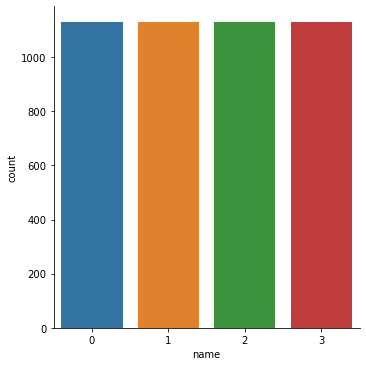

In [8]:
sns.catplot(x = 'name', kind='count', data=df_allTweets)

In [75]:
# Split into train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(list(df_allTweets.tweetText), list(df_allTweets.name), test_size = 0.2)

# Generate the word vectors and remove stopwords/accents
train_X_vect = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1,2))
train_X_counts = train_X_vect.fit_transform(train_X)

# Apply tfidf on train set
tfidfTransformer = TfidfTransformer()
train_X_tfidf = tfidfTransformer.fit_transform(train_X_counts)

# Apply tfidf on test set
test_X_counts = train_X_vect.transform(test_X)
test_X_tfidf = tfidfTransformer.transform(test_X_counts)

# 
clf = MultinomialNB().fit(train_X_tfidf, train_Y)
prediction = clf.predict(test_X_tfidf)
sum(test_Y == prediction) / len(test_Y)

0.8839779005524862

In [76]:
test_X_counts = train_X_vect.transform(['aaa'])
test_X_tfidf = tfidfTransformer.transform(test_X_counts)

prediction_test = clf.predict(test_X_tfidf)
prediction_test[0]

2

In [77]:
import pickle
with open('D:/Development/Techonony/Intake exercise/Saved model/CLFmultinomialNB.pkl', 'wb') as file:
    pickle.dump(clf, file)
    
with open('D:/Development/Techonony/Intake exercise/Saved model/TfidfTransformer.pkl', 'wb') as file:
    pickle.dump(tfidfTransformer, file) 
    
with open('D:/Development/Techonony/Intake exercise/Saved model/train_X_vect.pkl', 'wb') as file:
    pickle.dump(train_X_vect, file) 

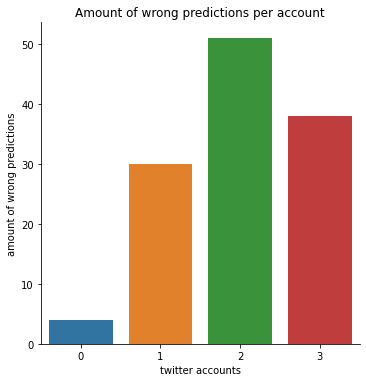

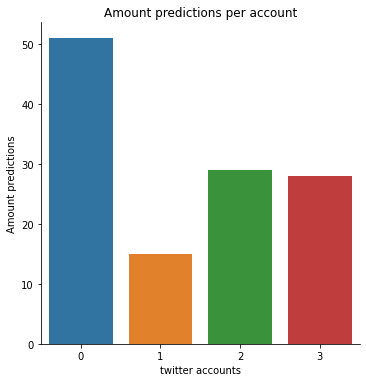

In [63]:
df_predictions = pd.DataFrame({'test':test_Y, 'prediction':prediction})

sns.catplot(x = 'test',kind='count', data= df_predictions[test_Y != prediction])
plt.xlabel('twitter accounts')
plt.ylabel('amount of wrong predictions')
plt.title('Amount of wrong predictions per account')
plt.show()


sns.catplot(x = 'prediction',kind='count', data= df_predictions[test_Y != prediction])
plt.xlabel('twitter accounts')
plt.ylabel('Amount predictions')
plt.title('Amount predictions per account')
plt.show()

In [24]:
df_predictions = pd.DataFrame({'test_X':test_X, 'prediction':prediction})

df_predictions[test_Y != prediction]

,test_X,prediction
6,i just want to stop the world from killing itself,0
17,beautiful fireworks in la tonight,2
20,today,0
27,alarm its one or if you dont have a car with p...,2
40,purposeparispopup,0
...,...,...
829,lord edge,0
884,whoever made this is hilarious,0
892,lnterestingmaps iearnsomethlng,0
893,congress to the team,0


In [28]:
df_predictions = pd.DataFrame({'test_X':test_X, 'test_Y':test_Y, 'prediction':prediction})

amountOfTweetsPerAccount = df_predictions.groupby(by="test_Y").count().test_X
df_wrongPredictions = df_predictions[test_Y != prediction]
wrongPredsPerAccount = df_wrongPredictions.groupby(by="test_Y").count().test_X

print(amountOfTweetsPerAccount)
print(wrongPredsPerAccount)
print(wrongPredsPerAccount / amountOfTweetsPerAccount)

# obama = 0
# elon = 1
# bieber = 2
# trump = 3

test_Y
0    208
1    210
2    250
3    237
Name: test_X, dtype: int64
test_Y
0     4
1    30
2    51
3    38
Name: test_X, dtype: int64
test_Y
0    0.019231
1    0.142857
2    0.204000
3    0.160338
Name: test_X, dtype: float64


https://medium.com/@martinpella/customers-tweets-classification-41cdca4e2de
https://www.youtube.com/watch?v=Y90BJzUcqlI
https://www.youtube.com/watch?v=XOdrsdhWpKE


In [258]:
# Clean the tweet texts
# remove retweets
df_tweets = df_elonMuskTweetsUnfiltered[~df_elonMuskTweetsUnfiltered.tweetText.str.contains("RT")].reset_index(drop=True)

# clean tweets
df_tweets["tweetText"] = df_tweets['tweetText'].apply(cleanTweet)

# remove empty tweets (tweets may be empty because of cleaning process)
df_tweets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_tweets[df_tweets['tweetText'] != '']

happy fathers day
teslaownerssv yeah
weddleandsons tell nice work
rationaletienne
udonandtempura tell hata pretty much
erdayastronaut this is epic very impressive history
teslaownerssv true
tell peak acceleration is over is which is faster than falling
billy hata
real pick of ships next to staircase wiki bar on right
donisiko proper motortrend tell true
proper motortrend tell steam engines are even better
erdayastronaut vincent give been driving with the yoke for a while amp its great iso progressive sneering would require complex hearing or drivebywire without direct mechanical link will aim for that in a few years
news congratulations this is a great achievement
teslarati ericralph nasaspaceflight thejackbeyer we might use sn on a hypersonic flight test
vincent fair enough
bitcoinmagazine bestow based on what data
adamhoov jasoncammisa cool
crabsareus hello in clark kent
wholemarsblog manufacturing is so hard i have the utmost respect for those who build things
dimazeniuk tell wholem

KeyboardInterrupt: 

In [259]:
df_tweets.loc[df_tweets.likes.nlargest(10).index]

,creationDate,tweetText,likes,retweets
1011,2021-02-04 07:57:30,ur welcome https://t.co/e2KF57KLxb,995462,147499
1199,2021-01-09 18:47:06,"My 14-year-old son, Saxon, said he feels like ...",921154,65088
647,2021-03-24 07:02:40,You can now buy a Tesla with Bitcoin,894684,113487
1167,2021-01-13 09:25:42,Legalize comedy,888310,87360
2978,2020-06-26 06:05:19,https://t.co/e9dPKVSjjl,845238,129937
909,2021-02-15 09:52:37,https://t.co/w11m1IAG0z,833210,77972
963,2021-02-07 22:25:14,🎶 Who let the Doge out 🎶,783233,113570
301,2021-05-07 21:05:35,Guest starring … https://t.co/buM3bTOWbX,770626,110190
1008,2021-02-04 08:27:10,"No highs, no lows, only Doge",769780,112821
635,2021-03-25 10:35:03,"If there’s ever a scandal about me, *please* c...",767755,56683


# ideas

- visualize most used words per person (defining words)
- percentage wrong per person
- https://towardsdatascience.com/text-classification-in-python-dd95d264c802
- look at model selection techniques and optimization in afstudeer opdracht file
- https://towardsdatascience.com/deploying-a-text-classification-model-7ad2d23a556d

In [ ]:
tanja